In [1]:
!pip install dmslogo

from google.colab import output
output.clear()

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm
tqdm.pandas()

pd.set_option('display.max_columns', None)

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import dmslogo

No GPU available


In [3]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','C','G','T']
        self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
constants = constants()

class utils():
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor

    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT,
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

# class utils():
##     @staticmethod
#     def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
#         seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
#         for letterIdx, letter in enumerate(sequence_str):
#             seq_tensor[vocab_list.index(letter), letterIdx] = 1
#         seq_tensor = torch.Tensor(seq_tensor)
#         return seq_tensor

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

# Load CODA library and contributions

In [4]:
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)

row_filter_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
coda_library_df = boda2_df[row_filter_1 | (boda2_df['method'] == 'fsp') ].reset_index(drop=True)

In [5]:
onehots_dict = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_onehots.pt')

cell_types = ['K562', 'HepG2', 'SKNSH']

contributions_dicts = {}
for cell_type in cell_types:
  contributions_dicts[cell_type] = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_contributions_{cell_type}.pt')

all_contributions = torch.stack([contributions_dicts[cell_type]['contributions'] for cell_type in cell_types], dim=0)
all_hyp_contributions = torch.stack([contributions_dicts[cell_type]['hyp_contributions'] for cell_type in cell_types], dim=0)

cell_colors = ['#00A79D', '#FBB040', '#ED1C24']

# Processed and hypothetical-contribution core motifs

In [6]:
tensor_motif_dict = torch.load("/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/modisco_plus_streme_core_motif_tensors.pt")
motif_ids = list(tensor_motif_dict.keys())

core_motif_ppms = list(tensor_motif_dict.values())
core_motif_pwms = [ppm_to_pwm(ppm) for ppm in core_motif_ppms]
core_motif_icms = [ppm_to_IC(ppm) for ppm in core_motif_ppms]

core_motif_ppms_rc = [utils.reverse_complement_onehot(ppm) for ppm in core_motif_ppms]
core_motif_pwms_rc = [utils.reverse_complement_onehot(pwm) for pwm in core_motif_pwms]
core_motif_icms_rc = [utils.reverse_complement_onehot(icm) for icm in core_motif_icms]

In [7]:
motif_hyp_scores_dict = torch.load("/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/modisco_plus_streme_core_hyp_scores.pt")

motif_ids = list(motif_hyp_scores_dict.keys())
fwd_motif_hyp_scores = list(motif_hyp_scores_dict.values())
rev_motif_hyp_scores = [utils.reverse_complement_onehot(motif) for motif in fwd_motif_hyp_scores]

In [8]:
# custom_motif_names = ['GATA3', 'ELK4', 'FOSB::JUNB', 'HNF1B', 'HNF4A', 'CREB1', 'RELA', 'SP1', 'TEAD4',
#                       'TP53', 'IRF4', 'STAT1', 'FOXB1', 'NR5A1', 'DBP', 'SOX4', 'SREBF2', 'FOXI1',
#                       'TCF7L1', 'EHF', 'FOXJ2', '*NRF1', 'IRF3', 'NFATC2 x2', 'TYY1', 'NRF1', 'POU3F4', 'MEF2B',
#                       'GFI1B', 'ID4', '*NFIB', 'STREME_1', 'STREME_2', 'MEIS2', 'STREME_4', '*HSF1'
#                       ]

custom_motif_names = ['(GATA3) P0b', '(ELK4) P1', '(FOSB::JUNB) P2', '(HNF1B) P3', '(HNF4A) P4', '(CREB1) P5', '(RELA) P6', '(SP1) P7',
                      '(TEAD4) P10b', '(TP53) P12', '(IRF4) P14', '(STAT1) P15', '(FOXB1) P16', '(NR5A1) P21', '(DBP) P22', '(SOX4) P23b',
                      '(SREBF2) P26', '(FOXI1) P27b', '(TCF7L1) P30', '(EHF) P31', '(FOXJ2) P32b', '(NRF1*) P33', '(IRF3) P34',
                      '(NFATC2x2) P39', '(TYY1) P44', '(NRF1) P46', '(POU3F4) P51b', '(MEF2B) P57b',
                      '(GFI1B) N0', '(ID4) N5', '(NFIB*) N6', 'S1', 'S2', '(MEIS2) S3', 'S4', '(HSF1*) S5'
                      ]

#Load contribution-based motif hits

In [9]:
contribution_fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_full.tsv', sep='\t')

In [10]:
#fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike_min_overlap.tsv', sep='\t')
fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike.tsv', sep='\t')

#Hits in OL50 sequences (restricted overlapping)

20211212_75659__621411__391::fsp__sknsh__0  |  K562 l2FC = -0.87,  HepG2 l2FC = -0.31,  SKNSH l2FC = 4.52


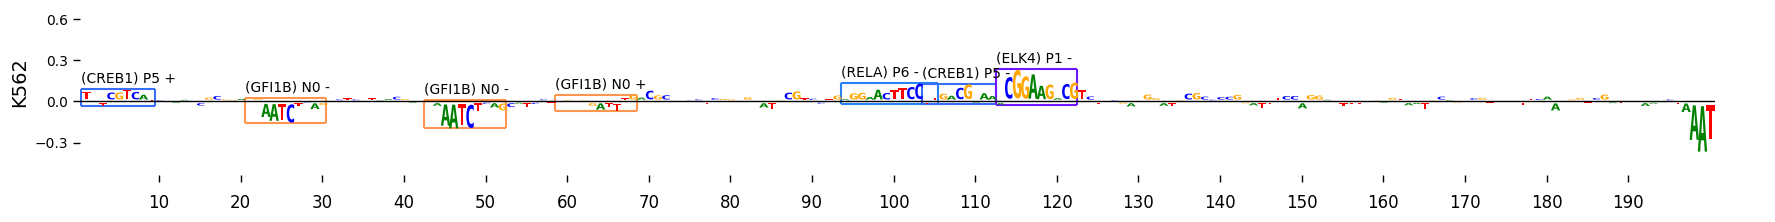

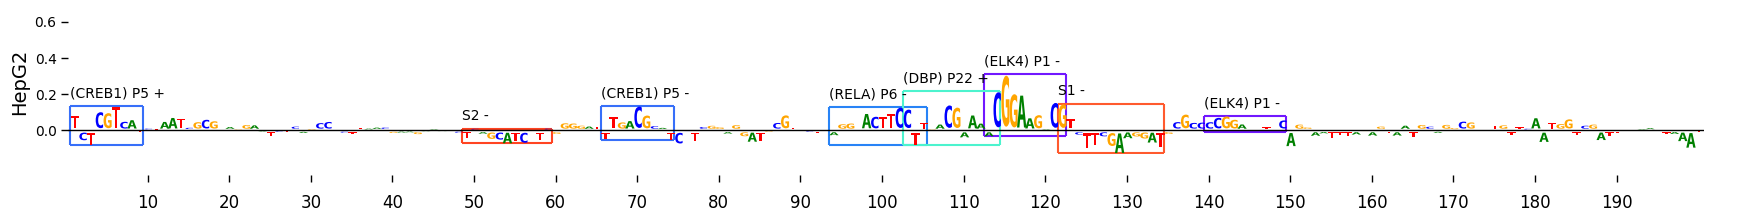

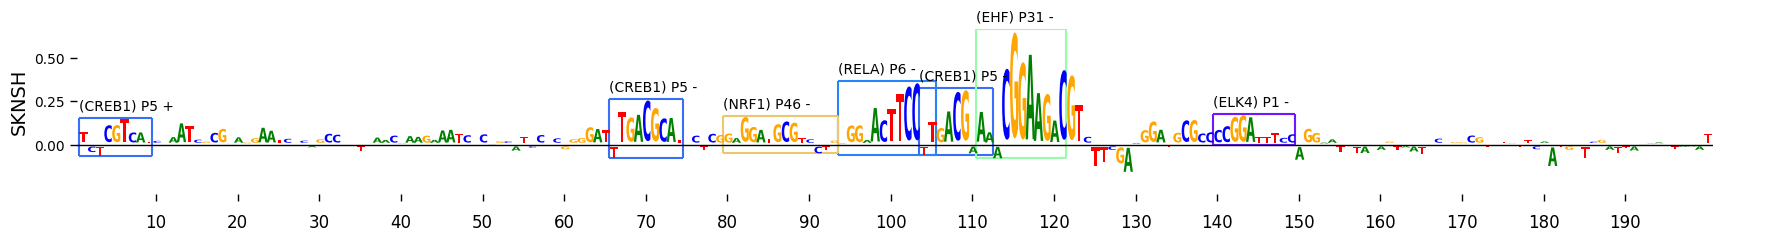

In [20]:
# seq_ids = ['20211206_221956__59439361__2140::al__k562__0',
#     '20211206_24503__33072627__1223::al__hepg2__0',
#     '20211206_24503__33072627__1816::al__hepg2__0',
#     '20211207_100944__255626__132::sa__hepg2__0',
#     '20211207_205407__862697__385::sa__k562__0',
#     '20211207_63610__124703__1517::sa__hepg2__0',
#     '20211212_45907__313665__1548::fsp__hepg2__5',
#     '20211212_45907__313665__213::fsp__hepg2__0',
#     '20211212_61436__944763__262::fsp__hepg2__0',
#     '20211212_85225__619474__1260::fsp__k562__4',
#     '20211212_85225__619474__1680::fsp__k562__5',
#     '20211212_85225__619474__194::fsp__k562__0',
#     '20211212_92818__893131__1479::fsp__k562__4'
#                 ]

#seq_ids = ['20211212_52639__969454__185::fsp__hepg2__0']

# seq_ids = coda_library_df[(coda_library_df['target_cell'] == 'hepg2') & \
#  ((coda_library_df['method'] == 'gs'))].sort_values(by='OverMax', ascending=False)['ID'].tolist()[25:26]

seq_ids = ['20211212_75659__621411__391::fsp__sknsh__0']

intersection_threshold = 5
box_linewidth = 1.5
cmap = plt.get_cmap('rainbow', len(motif_ids))

color_dict = dict(zip(2 * motif_ids, 2*[cmap(i) for i in range(len(motif_ids))]))
motif_short_names_dict = dict(zip(motif_ids, custom_motif_names))
strand_dict = {'fwd': '+', 'rev': '-'}
for order_idx, seq_id in enumerate(seq_ids):

    seq_df = coda_library_df[coda_library_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}')

    y_max = all_contributions[:, seq_idx, ...].max()
    for cell_idx, cell_type in enumerate(cell_types):
        seq_scan_df = contribution_fimo_df[(contribution_fimo_df['sequence_name'] == seq_id) & (contribution_fimo_df['cell_type'] == cell_type)]
        seq_scan_df = seq_scan_df.sort_values('gradients_pearson', ascending=False).reset_index(drop=True)

        seq_contributions = all_contributions[cell_idx, seq_idx, ...]
        #y_max = seq_contributions.max()

        find_motif_names  = []
        print_motif_names = []
        motifs_start_ends = []
        orientations      = []
        cover_set         = set()
        num_hits = len(seq_scan_df)
        for i in range(num_hits):
            hit_row = seq_scan_df.iloc[i]
            m_start, m_end = max(0, hit_row['start']), min(200, hit_row['stop'])
            motif_range = set(np.arange(m_start, m_end))
            motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
            pos_contribution = motif_contributions.max()
            neg_contribution = motif_contributions.min()
            contribution_condition = True #(pos_contribution > 0.06) or (neg_contribution < -0.02)
            if (len(cover_set & motif_range) <= intersection_threshold) and contribution_condition:
                find_motif_names.append(hit_row['motif_id'])
                print_motif_names.append(hit_row['motif_alt_id'])
                motifs_start_ends.append((m_start, m_end))
                orientations.append(hit_row['strand'])
                cover_set = cover_set | motif_range
            find_motif_short_names = [name + ' ' + str(strand) for name, strand in zip(find_motif_names, orientations)]
            #print_short_names = [name + ' (' + str(strand) + ')' for name, strand in zip(print_motif_names, orientations)]
            #print_short_names = [name for name, strand in zip(print_motif_names, orientations)]
            print_short_names = [motif_short_names_dict[name] + ' ' + strand_dict[str(strand)] \
                                 for name, strand in zip(find_motif_names, orientations)]

        matrix_plot = seq_contributions.clone()
        contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                            for m_start, m_end in motifs_start_ends]
        fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                            fontaspect=0.5, widthscale=0.3, axisfontscale=0.6, heightscale=0.75)
        for idx, motif_name in enumerate(find_motif_names):
            try:
                color = color_dict[motif_name]
            except:
                color = color_dict[f'{motif_name}b']
            plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=box_linewidth)
            plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=box_linewidth)
            plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=box_linewidth)
            plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=box_linewidth)

            #text = f'{find_motif_short_names[idx]}'#' ({motif_pct_select[idx]}%)'
            text = f'{print_short_names[idx]}'
            # if text.split('_')[0] == 'STREME':
            #     streme_idx = text.split('_')[1]
            #     text = f'(Novel) S{streme_idx}'
            x = motifs_start_ends[idx][0]
            y = contrib_min_maxs[idx][1] + 0.05
            plt.text(x, y, text, fontsize=10, rotation=0)
        ax.spines['bottom'].set_position(('outward', 15))
        plt.xticks(np.arange(9, 199, 10)+0.5, labels=np.arange(9, 199, 10)+1, fontsize=12, y=-0.05, rotation=0)
        #ax.tick_params(axis='x', which='major', pad=10, length=0)
        plt.xlabel('')

        #ax.axes.get_xaxis().set_visible(False)
        #ax.axes.get_yaxis().set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        plt.margins(x=0)
        plt.ylabel(f'{cell_type}', fontsize=14)
        plt.yticks(fontsize=10)
        plt.savefig(f'{seq_id}_contributions_{cell_type}.pdf', format='pdf', dpi=150, bbox_inches='tight', transparent=True)
        plt.show()

    print()

In [18]:
fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike_min_overlap.tsv', sep='\t')

20211212_52639__969454__185::fsp__hepg2__0
       K562_signal  HepG2_signal  SKNSH_signal
27935    -0.787379      5.526433     -2.181965
       K562_pred_aggreg  HepG2_pred_aggreg  SKNSH_pred_aggreg
27935         -0.751453          10.927252          -0.877665


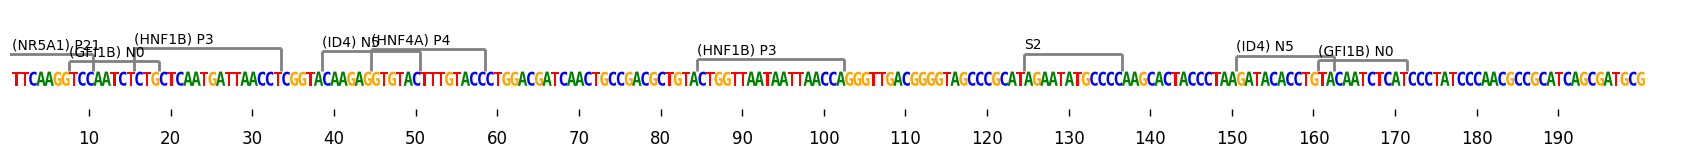

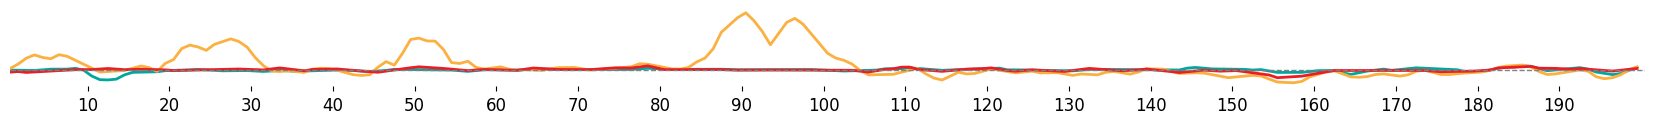

[-1.132537603378296, 11.138721466064453, -0.8462364673614502]

20211212_75659__621411__391::fsp__sknsh__0
       K562_signal  HepG2_signal  SKNSH_signal
47891    -0.866327     -0.314954      4.515997
       K562_pred_aggreg  HepG2_pred_aggreg  SKNSH_pred_aggreg
47891         -1.135667          -0.072624           4.762061


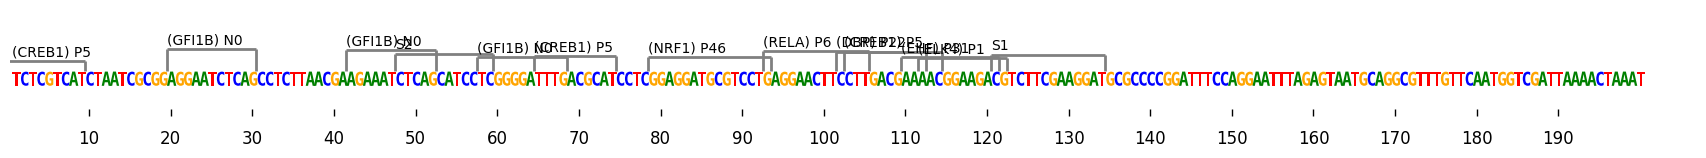

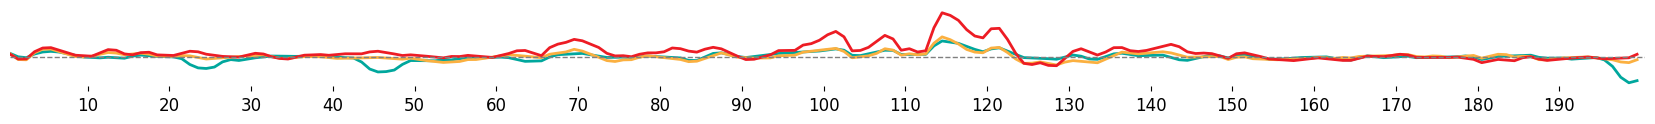

[0.964711606502533, 2.981424331665039, 12.64877700805664]



In [19]:
selected_ids = [
                '20211212_52639__969454__185::fsp__hepg2__0',
                '20211212_75659__621411__391::fsp__sknsh__0'
                ]

cell_colors = ['#00A79D', '#FBB040', '#ED1C24']

motif_short_names_dict = dict(zip(motif_ids, custom_motif_names))

cm = plt.get_cmap('gist_rainbow')
#cm = plt.get_cmap('tab20b')
#color_dict = dict(zip(boda2_streme_tfs['motif_id'], [cm(1.*i/len(boda2_streme_tfs)) for i in range(len(boda2_streme_tfs))]))

for single_seq_id in selected_ids:
    print(single_seq_id)
    #--- Get sequence and contributions
    single_seq_df = coda_library_df[coda_library_df['ID'] == single_seq_id]
    seq_idx = single_seq_df.index.item()
    test_str = single_seq_df['sequence'].item()
    test_onehot = utils.dna2tensor(test_str).view(4,-1)
    seq_contribution_tensor = all_contributions[:, seq_idx, ...]
    # seq_contribution_tensor = torch.stack([str2tensor(single_seq_df[contribution_column].item()).repeat(4,1) * test_onehot \
    #                                        for contribution_column in contribution_columns])

    #--- Get FIMO hits
    seq_scan_df = fimo_df[fimo_df['sequence_name'] == single_seq_id].sort_values('start')[:-1]
    seq_scan_df = seq_scan_df[~seq_scan_df[['motif_id', 'start', 'stop']].duplicated()]
    #seq_scan_df = seq_scan_df[seq_scan_df['motif_id'] != '73-GTTAATGATTAA']
    #seq_scan_df = seq_scan_df[seq_scan_df['motif_id'] != '36-GCACAGATTKSA']

    print(single_seq_df[['K562_signal', 'HepG2_signal', 'SKNSH_signal']])
    print(single_seq_df[['K562_pred_aggreg', 'HepG2_pred_aggreg', 'SKNSH_pred_aggreg']])

    find_motif_names  = []
    motifs_start_ends = []
    orientations      = []
    num_hits = len(seq_scan_df)
    for i in range(num_hits):
        hit_row = seq_scan_df.iloc[i]
        m_start, m_end = int(hit_row['start'] - 1), int(hit_row['stop'])
        motif_range = set(np.arange(m_start, m_end))
        find_motif_names.append(hit_row['motif_id'])
        motifs_start_ends.append((m_start, m_end))
        orientations.append(hit_row['strand'])

    #--- Plot logo and FIMO hits
    fig, ax = matrix_to_dms(test_onehot, y_max=3, colors=['green','blue','orange','red'], \
                            fontaspect=0.5, widthscale=0.3, axisfontscale=0.6, heightscale=0.25)

    y_bottom = 1
    y_top = 1.5
    for idx, motif_name in enumerate(find_motif_names):
        color = 'gray' #color_dict[motif_name]
        noised_y_top = y_top + 1.0 * float(np.random.rand(1))
        noised_x = max(0, motifs_start_ends[idx][0])

        if motif_name == '1-RGTTAATSATTAACY':
            noised_y_top = 2.5
            noised_x = motifs_start_ends[idx][0] + 3
        elif motif_name == '27-ATCAACCCGAGTGGA':
            noised_y_top = 1.5
            noised_x = motifs_start_ends[idx][0] + 9
        elif motif_name == '2-GCHGTGATTTAY':
            noised_y_top = 1.3
            noised_x = motifs_start_ends[idx][0] + 5
        elif motif_name == '70-CAAAGTCCA':
            noised_y_top = 2.5
            noised_x = motifs_start_ends[idx][0] + -2
        elif motif_name == '3-GGTYCAAAGTCCAHH':
            noised_y_top = 2.5
            noised_x = motifs_start_ends[idx][0] + 5
        elif motif_name == '13-DTGCACCTGC':
            noised_y_top = 1.5
            noised_x = motifs_start_ends[idx][0] + 0

        plt.vlines(motifs_start_ends[idx][0], y_bottom, noised_y_top, linestyles='solid', colors=color, linewidth=2.0)
        plt.vlines(motifs_start_ends[idx][1], y_bottom, noised_y_top, linestyles='solid', colors=color, linewidth=2.0)
        #plt.hlines(y_bottom, motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=2.0)
        plt.hlines(noised_y_top, motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=2.0)

        text = f'{motif_short_names_dict[motif_name]}'# ({orientations[idx]})'
        x = max(0, motifs_start_ends[idx][0])
        #x = int(0.5 * (motifs_start_ends[idx][0] + motifs_start_ends[idx][1]) + np.random.rand(1))
        y = noised_y_top + 0.3
        #plt.text(x, y, text, fontsize=10, rotation=90)
        plt.text(noised_x, y, text, fontsize=10, rotation=0)

    # plt.axis('off')
    ax.spines['bottom'].set_position(('outward', 15))
    plt.xticks(np.arange(9, 199, 10)+0.5, labels=np.arange(9, 199, 10)+1, fontsize=12, y=-0.2, rotation=0)
    #ax.tick_params(axis='x', which='major', pad=10, length=0)
    plt.xlabel('')
    #ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.margins(x=0)
    save_path = f'/content/drive/MyDrive/figures/contribution_scores_examples/min8_motifs_hits_invivo_seqs/{single_seq_id}_hits_fig3_revised.pdf'
    #plt.savefig(save_path, format='pdf', dpi=150, bbox_inches='tight', transparent=True)
    plt.show()

    #--- Plot contribution tracks
    contrib_tracks = seq_contribution_tensor.sum(dim=1).numpy()
    with plt.style.context('fast'):
        plt.figure(figsize=(21.1, 1))
        for i in range(3):
            ysmoothed = gaussian_filter1d(contrib_tracks[i,:], sigma=0.75)
            plt.plot(ysmoothed, color=cell_colors[i], linewidth=2)
        plt.hlines(0, 0, 200, linestyles='dashed', colors='grey', linewidth=1.0)
        plt.margins(x=0)
        plt.xticks(np.arange(9, 199, 10)+0.5, labels=np.arange(9, 199, 10)+1, fontsize=12)
        plt.yticks([])
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        #plt.axis('off')
        save_path = f'/content/drive/MyDrive/figures/contribution_scores_examples/min8_motifs_hits_invivo_seqs/{single_seq_id}_contributions_fig3_revised.pdf'
        #plt.savefig(save_path, format='pdf', dpi=150, bbox_inches='tight', transparent=True)
        plt.show()

    print(contrib_tracks.sum(axis=-1).tolist())
    print('')

20211206_24503__33072627__1223::al__hepg2__0
       K562_signal  HepG2_signal  SKNSH_signal
13259    -0.640067      4.536725     -1.210069
       K562_pred_aggreg  HepG2_pred_aggreg  SKNSH_pred_aggreg
13259         -1.473612           3.897686          -1.561373


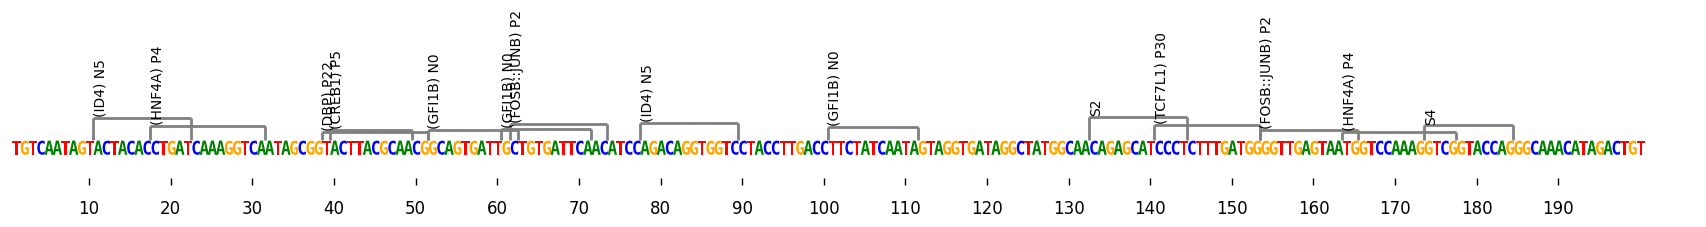

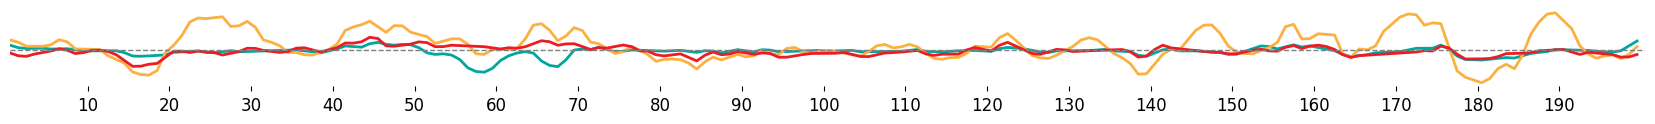

[-1.6721436977386475, 6.198469161987305, -1.1534671783447266]

20211206_24503__33072627__1816::al__hepg2__0
       K562_signal  HepG2_signal  SKNSH_signal
13826    -1.265041      4.496574     -1.623743
       K562_pred_aggreg  HepG2_pred_aggreg  SKNSH_pred_aggreg
13826         -1.687145           4.563019          -1.542181


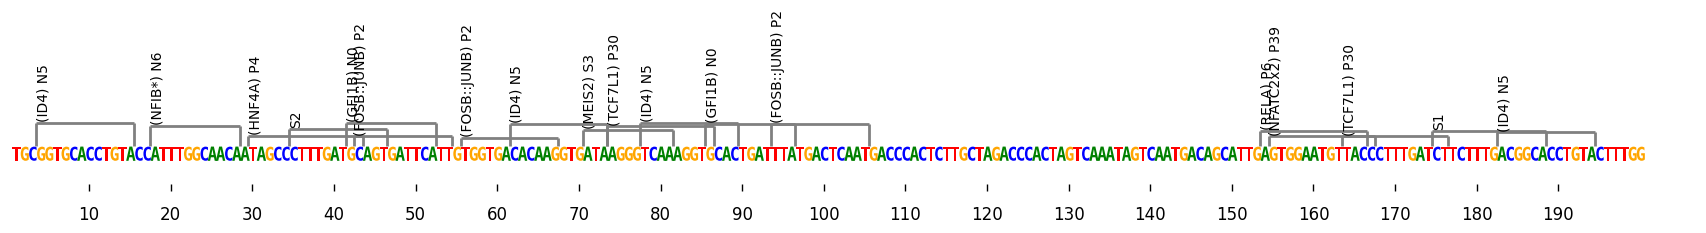

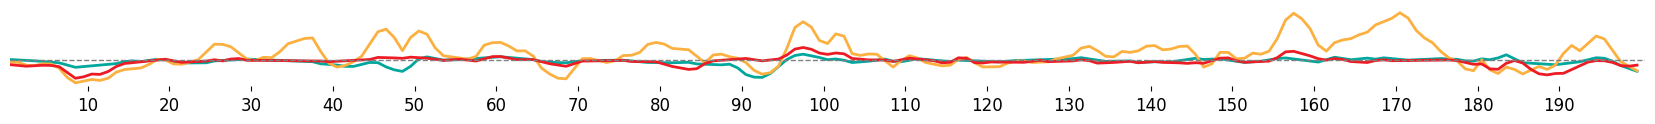

[-1.9102199077606201, 8.793892860412598, -2.0548248291015625]

20211207_100944__255626__132::sa__hepg2__0
      K562_signal  HepG2_signal  SKNSH_signal
2466    -0.686803      6.034644     -1.087801
      K562_pred_aggreg  HepG2_pred_aggreg  SKNSH_pred_aggreg
2466          -0.74098           6.233065          -0.691755


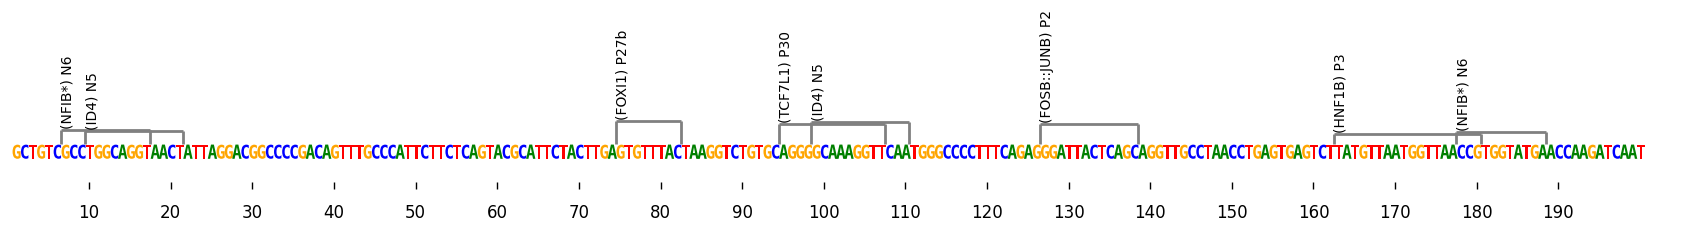

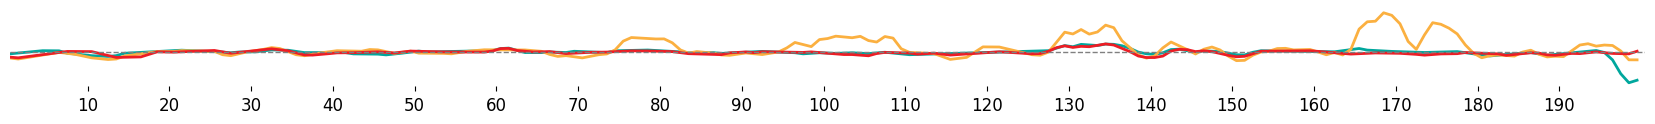

[-0.9349647164344788, 6.310052871704102, -1.5252113342285156]

20211212_75659__621411__391::fsp__sknsh__0
       K562_signal  HepG2_signal  SKNSH_signal
47891    -0.866327     -0.314954      4.515997
       K562_pred_aggreg  HepG2_pred_aggreg  SKNSH_pred_aggreg
47891         -1.135667          -0.072624           4.762061


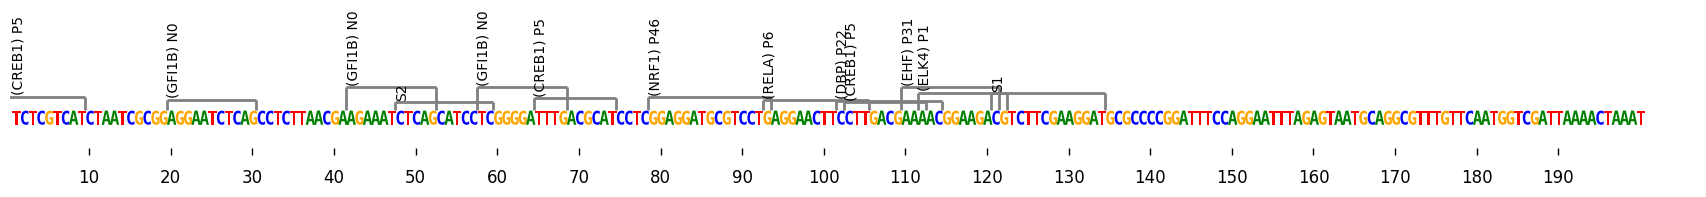

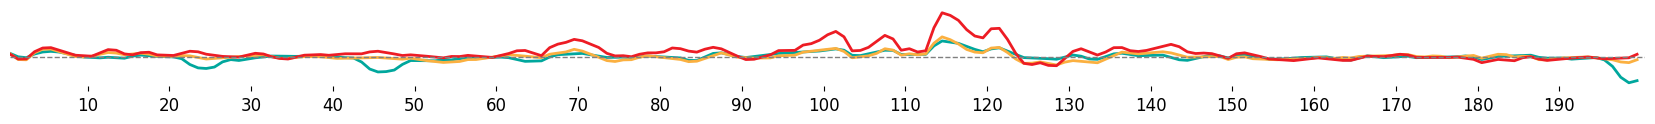

[0.964711606502533, 2.981424331665039, 12.64877700805664]

20211207_212124__46481152__2927::al__sknsh__0
       K562_signal  HepG2_signal  SKNSH_signal
22883    -0.356682     -0.227919      2.857992
       K562_pred_aggreg  HepG2_pred_aggreg  SKNSH_pred_aggreg
22883         -0.757103          -0.760395           4.194355


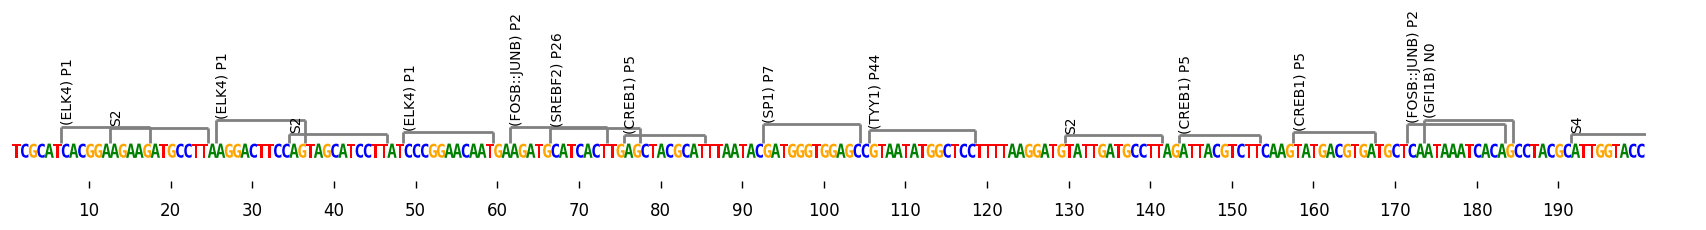

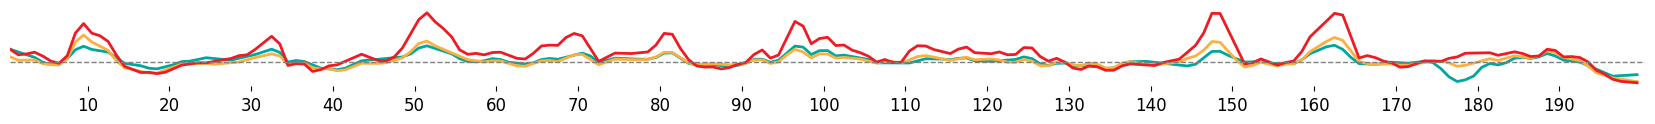

[2.2821860313415527, 2.3750343322753906, 13.009941101074219]

20211207_152258__777391__191::sa__sknsh__0
      K562_signal  HepG2_signal  SKNSH_signal
8904    -0.426725     -0.114046      3.615757
      K562_pred_aggreg  HepG2_pred_aggreg  SKNSH_pred_aggreg
8904          -0.79163          -0.441454           4.862652


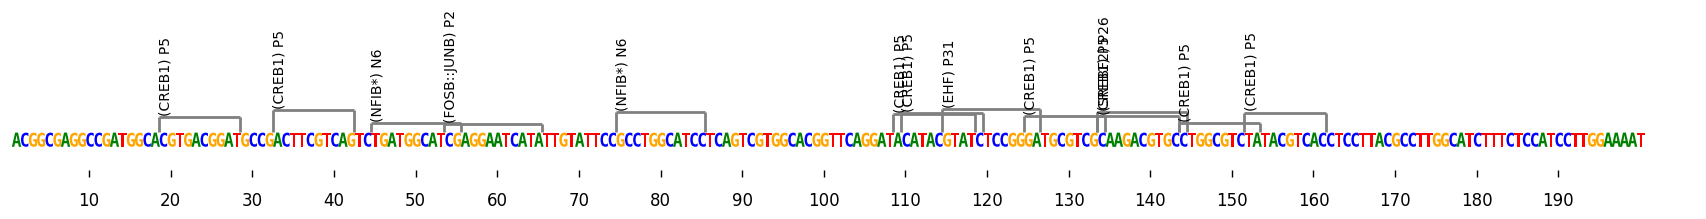

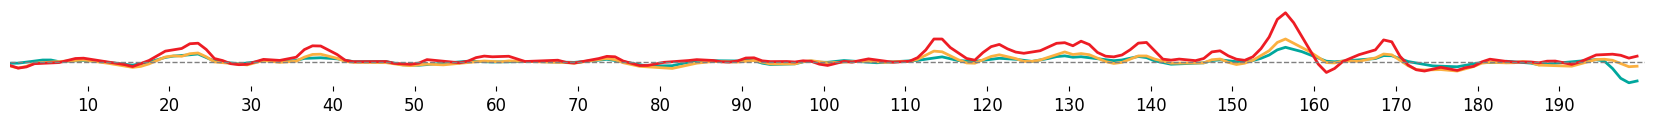

[2.085982084274292, 2.354766607284546, 13.216562271118164]



In [27]:
selected_ids = [
                '20211206_24503__33072627__1223::al__hepg2__0','20211206_24503__33072627__1816::al__hepg2__0','20211207_100944__255626__132::sa__hepg2__0',
                '20211212_75659__621411__391::fsp__sknsh__0','20211207_212124__46481152__2927::al__sknsh__0','20211207_152258__777391__191::sa__sknsh__0'
                ]

cell_colors = ['#00A79D', '#FBB040', '#ED1C24']

motif_short_names_dict = dict(zip(motif_ids, custom_motif_names))

cm = plt.get_cmap('gist_rainbow')
#cm = plt.get_cmap('tab20b')
#color_dict = dict(zip(boda2_streme_tfs['motif_id'], [cm(1.*i/len(boda2_streme_tfs)) for i in range(len(boda2_streme_tfs))]))

for single_seq_id in selected_ids:
    print(single_seq_id)
    #--- Get sequence and contributions
    single_seq_df = coda_library_df[coda_library_df['ID'] == single_seq_id]
    seq_idx = single_seq_df.index.item()
    test_str = single_seq_df['sequence'].item()
    test_onehot = utils.dna2tensor(test_str).view(4,-1)
    seq_contribution_tensor = all_contributions[:, seq_idx, ...]
    # seq_contribution_tensor = torch.stack([str2tensor(single_seq_df[contribution_column].item()).repeat(4,1) * test_onehot \
    #                                        for contribution_column in contribution_columns])

    #--- Get FIMO hits
    seq_scan_df = fimo_df[fimo_df['sequence_name'] == single_seq_id].sort_values('start')[:-1]
    seq_scan_df = seq_scan_df[~seq_scan_df[['motif_id', 'start', 'stop']].duplicated()]
    #seq_scan_df = seq_scan_df[seq_scan_df['motif_id'] != '73-GTTAATGATTAA']
    #seq_scan_df = seq_scan_df[seq_scan_df['motif_id'] != '36-GCACAGATTKSA']

    print(single_seq_df[['K562_signal', 'HepG2_signal', 'SKNSH_signal']])
    print(single_seq_df[['K562_pred_aggreg', 'HepG2_pred_aggreg', 'SKNSH_pred_aggreg']])

    find_motif_names  = []
    motifs_start_ends = []
    orientations      = []
    num_hits = len(seq_scan_df)
    for i in range(num_hits):
        hit_row = seq_scan_df.iloc[i]
        m_start, m_end = int(hit_row['start'] - 1), int(hit_row['stop'])
        motif_range = set(np.arange(m_start, m_end))
        find_motif_names.append(hit_row['motif_id'])
        motifs_start_ends.append((m_start, m_end))
        orientations.append(hit_row['strand'])

    #--- Plot logo and FIMO hits
    fig, ax = matrix_to_dms(test_onehot, y_max=3, colors=['green','blue','orange','red'], \
                            fontaspect=0.5, widthscale=0.3, axisfontscale=0.6, heightscale=0.25)

    y_bottom = 1
    y_top = 1.5
    for idx, motif_name in enumerate(find_motif_names):
        color = 'gray' #color_dict[motif_name]
        noised_y_top = y_top + 1.0 * float(np.random.rand(1))
        noised_x = max(0, motifs_start_ends[idx][0])

        if motif_name == '1-RGTTAATSATTAACY':
            noised_y_top = 2.5
            noised_x = motifs_start_ends[idx][0] + 3
        elif motif_name == '27-ATCAACCCGAGTGGA':
            noised_y_top = 1.5
            noised_x = motifs_start_ends[idx][0] + 9
        elif motif_name == '2-GCHGTGATTTAY':
            noised_y_top = 1.3
            noised_x = motifs_start_ends[idx][0] + 5
        elif motif_name == '70-CAAAGTCCA':
            noised_y_top = 2.5
            noised_x = motifs_start_ends[idx][0] + -2
        elif motif_name == '3-GGTYCAAAGTCCAHH':
            noised_y_top = 2.5
            noised_x = motifs_start_ends[idx][0] + 5
        elif motif_name == '13-DTGCACCTGC':
            noised_y_top = 1.5
            noised_x = motifs_start_ends[idx][0] + 0

        plt.vlines(motifs_start_ends[idx][0], y_bottom, noised_y_top, linestyles='solid', colors=color, linewidth=2.0)
        plt.vlines(motifs_start_ends[idx][1], y_bottom, noised_y_top, linestyles='solid', colors=color, linewidth=2.0)
        #plt.hlines(y_bottom, motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=2.0)
        plt.hlines(noised_y_top, motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=2.0)

        text = f'{motif_short_names_dict[motif_name]}'# ({orientations[idx]})'
        x = max(0, motifs_start_ends[idx][0])
        #x = int(0.5 * (motifs_start_ends[idx][0] + motifs_start_ends[idx][1]) + np.random.rand(1))
        y = noised_y_top + 0.3
        #plt.text(x, y, text, fontsize=10, rotation=90)
        plt.text(noised_x, y, text, fontsize=10, rotation=90)

    # plt.axis('off')
    ax.spines['bottom'].set_position(('outward', 15))
    plt.xticks(np.arange(9, 199, 10)+0.5, labels=np.arange(9, 199, 10)+1, fontsize=12, y=-0.2, rotation=0)
    #ax.tick_params(axis='x', which='major', pad=10, length=0)
    plt.xlabel('')
    #ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.margins(x=0)
    save_path = f'/content/drive/MyDrive/figures/contribution_scores_examples/core_motifs_hits_invivo_seqs/{single_seq_id}_hits_supfig22_revised.pdf'
    plt.savefig(save_path, format='pdf', dpi=150, bbox_inches='tight', transparent=True)
    plt.show()

    #--- Plot contribution tracks
    contrib_tracks = seq_contribution_tensor.sum(dim=1).numpy()
    with plt.style.context('fast'):
        plt.figure(figsize=(21.1, 1))
        for i in range(3):
            ysmoothed = gaussian_filter1d(contrib_tracks[i,:], sigma=0.75)
            plt.plot(ysmoothed, color=cell_colors[i], linewidth=2)
        plt.hlines(0, 0, 200, linestyles='dashed', colors='grey', linewidth=1.0)
        plt.margins(x=0)
        plt.xticks(np.arange(9, 199, 10)+0.5, labels=np.arange(9, 199, 10)+1, fontsize=12)
        plt.yticks([])
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        #plt.axis('off')
        save_path = f'/content/drive/MyDrive/figures/contribution_scores_examples/core_motifs_hits_invivo_seqs/{single_seq_id}_contributions_supfig22_revised.pdf'
        plt.savefig(save_path, format='pdf', dpi=150, bbox_inches='tight', transparent=True)
        plt.show()

    print(contrib_tracks.sum(axis=-1).tolist())
    print('')